# K-Nearest Neighbors
### Modelo 08
- TfidfVectorizer
- Base B


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_b.csv')

df.head()

,nome,categoria
0,BRAHMA,BRAHMA
1,BRAHMA 550ML,BRAHMA
2,BRAHMA CERV 350ML LT,BRAHMA
3,BRAHMA CERVEJA 350ML,BRAHMA
4,BRAHMA CERVEJA 350ML LT,BRAHMA


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,BRAHMA,0
1,BRAHMA 550ML,0
2,BRAHMA CERV 350ML LT,0
3,BRAHMA CERVEJA 350ML,0
4,BRAHMA CERVEJA 350ML LT,0


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Lista de Stop Words

In [5]:
stopwords_arquivo = pd.read_csv('../../stopwords.csv')

lista_stop_words = [ token(word)[0] for word in stopwords_arquivo.stopwords.values ]

#### Separa base de treino e teste

In [6]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome, 
    df.categoria,
    test_size = 0.3, 
    random_state = 42
)

#### Define TfidfVectorizer

In [7]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=token,
    ngram_range=(1,1),
    stop_words=lista_stop_words
)

#### Cria vocabulário

In [8]:
X_train = tfidf_vectorizer.fit_transform(X_train.values)

## Etapa de treinamento
#### Busca melhor valor para k

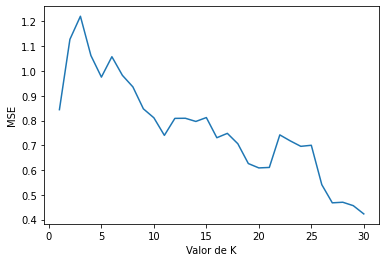

In [9]:
best_rmse = 1
k_neighbors = 0

k_range = range(1, 31)
k_scores = []
for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    loss = abs(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
    if loss.mean() < best_rmse:
        best_rmse = loss.mean()
        k_neighbors = k
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K')
plt.ylabel('MSE')
plt.show()

#### Cria um classificador kNN

In [10]:
knn = KNeighborsClassifier(n_neighbors = k_neighbors)

#### Treina o classificador

In [11]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

## Etapa de Teste

#### Efetua a predição

In [12]:
Y_Pred = knn.predict(tfidf_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [13]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 92.2
precisao: 93.1


#### Tabela com os itens classificados errados na base de teste

In [14]:
d = []

for i in range(len(X_test)):
    au = tfidf_vectorizer.transform([X_test.values[i]])
    pred = knn.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,IFOOD SUCO DE LARANJA INTG 300,SUCO LARANJA INTEGRAL,SUCO LARANJA
1,SUCO SU FRESH UVA 1L,SUCO UVA,SPRITE
2,DEL VALLE UVA INTEGRAL 1L 100 SUCO,SUCO UVA INTEGRAL,SUCO UVA
3,SUCO UVA Q MORGADO TTO 1500ML,SUCO UVA,SUCO LARANJA
4,SUCO D VALLE FRESH 1 5L UVA PET,SUCO UVA,SUCO LARANJA
...,...,...,...
65,CAMPO LARGO SUCO PET UVA INT 250,SUCO UVA INTEGRAL,SUCO UVA
66,REF DES.CINI WINI 2L GUARANA,CINI REFRIGERANTE,GUARANA ANTARTICA
67,SUCO NATURAL ONE SPECIAL BLEND UVA 900ML,SUCO UVA,SUCO LARANJA
68,REFRIG COCA COLA ZER,COCA-COLA,COCA-COLA ZERO


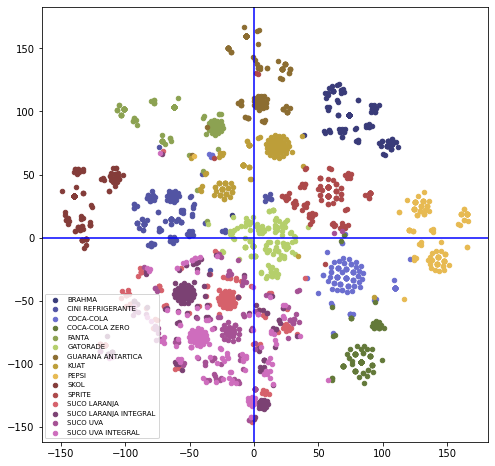

In [15]:
model = TSNE(n_components=2, init='pca', random_state=0)
transformed = model.fit_transform(X_train.todense())

fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], c=[plt.cm.tab20b(float(g)/15)], s=20, label = le.inverse_transform([g])[0])

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Matriz de Confusão

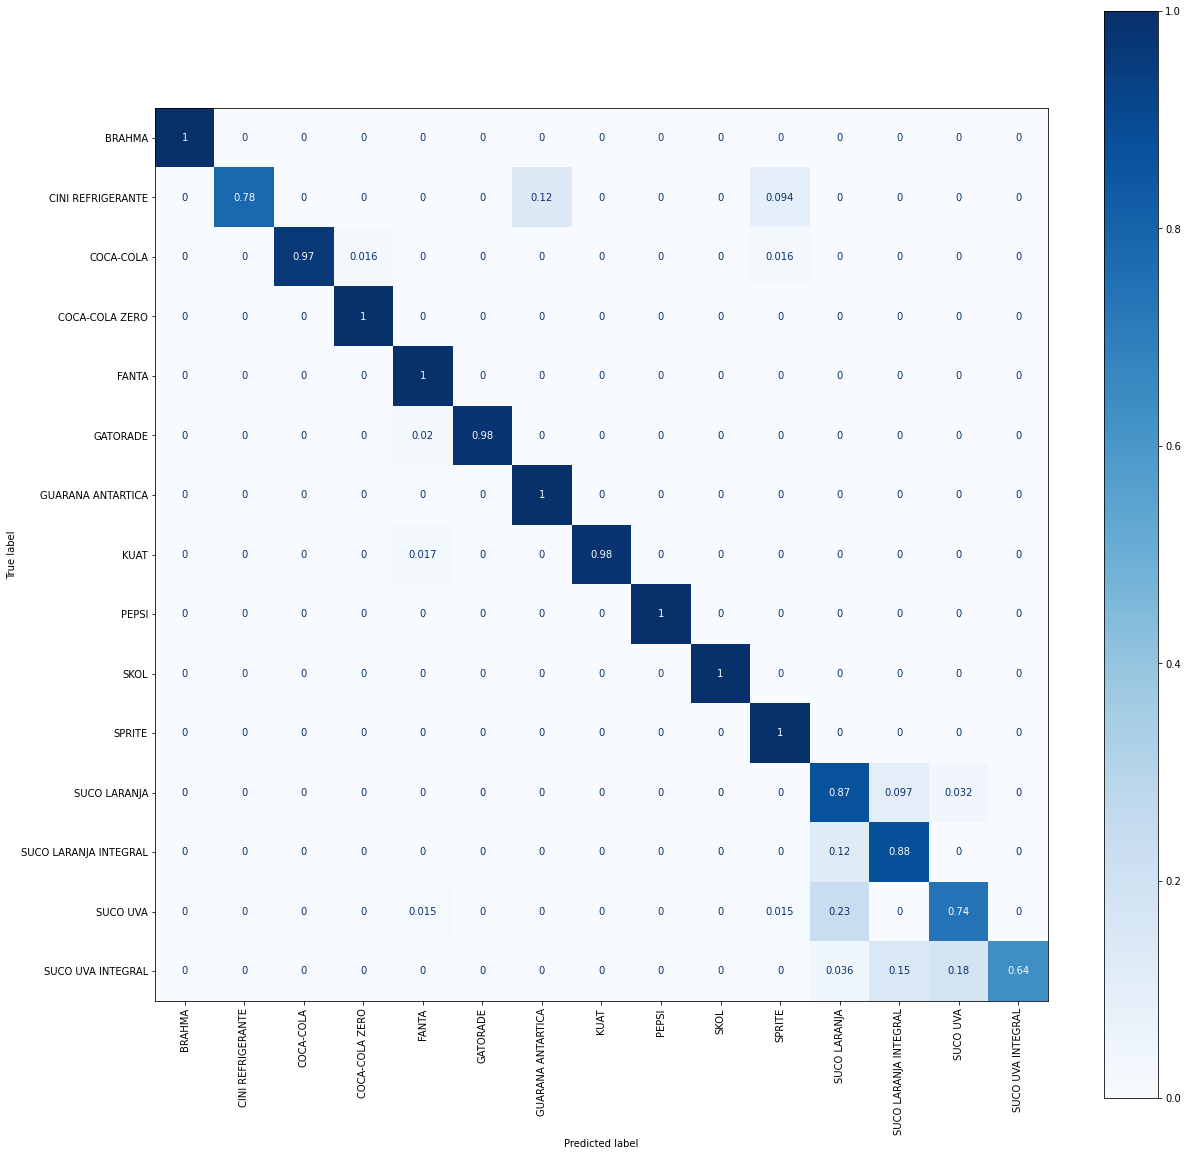

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(
    knn,
    tfidf_vectorizer.transform(X_test).toarray(),
    y_test,
    display_labels=np.unique(le.inverse_transform(y_test)),
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax,
    xticks_rotation='vertical'
)